ABOUT THIS SCRIPT

This script takes a csv file exported from the Consultations project in the Research IT Operations Asana: https://app.asana.com/0/531982708588662/list

The script manipulates each row of the spreadsheet as a list. It uses list notation to refer to each column -- or what had been a column in the spreadsheet. For convenience, here are the list indices and headers associated with each column: 

| Index | Column header |
| ------| ------------- |
| [0]   | Task ID |
| [1]   | Created At |
| [2]   | Completed At |
| [3]   | Last Modified |
| [4]   | Name |
| [5]   | Assignee |
| [6]   | Assignee Email |
| [7]   | Start Date |
| [8]   | Due Date |
| [9]   | Tags |
| [10]  | Notes |
| [11]  | Projects |
| [12]  | Parent Task |
| [13]  | Researcher |
| [14]  | Position |
| [15]  | PI/Lab |
| [16]  | Department / ORU |
| [17]  | RIT Service Area |
| [18]  | RIT Service Area 2 |
| [19]  | RIT Service Area 3 |
| [20]  | Source (referrer) |
| [21]  | Hand-off and/or referral |
| [22]  | Complexity |

IMPORT STATEMENTS

In [1]:
import csv, sys
import re
from collections import Counter
from datetime import date, datetime

DATA INPUT CONFIGURATION

The .csv file containing the data is now generated from the Consultations project in Asana, 
then filtered for date and the tag 'RDM'.

These are the parameters (arguments) that must be provided to the script:
1. The filepath that points to the .csv file containing our data (which is now being generated from the the Consultations project in Asana).
2. The filename of the .csv file.
3. The 'report_period_descriptor' will be the text included in the first line of the report created by the script.
4. The 'report_start' is the earliest consultation start date of the period covered by the report.
5. The 'report_end' is the latest consultation start date of the period covered by the report

You can load these from a file if you wish. The file should be a .py file that contains exactly the information shown below in lines 2 through 7. Place the file in the same folder as this Jupyter Notebook file, or provide the path to it in the cell magic command '%load.' (Remove the '#' before '%load' to run the command.)

In [2]:
# %load Metrics_args_Asana/RDM_metrics_Asana_FY2018_Q3.py
# These are the arguments provided to the script
# Replace filepath with path on your machine

filepath = '/Users/rjaffe/Documents/RDM/RDM_Metrics/MetricsData/data-from-asana/June2018-Metrics/'
filename = 'Consultations_20180626-1706PT.csv'
report_period_descriptor = 'the period from January 1, 2018 through March 31, 2018'
report_start = '2018-01-01'
report_end = '2018-03-31'


DICTIONARY CONFIGURATION

This script utilizes dictionaries to store values for counting and to aggregate ("roll up"") individual values 
under parent values. There are dictionaries for:
1. The consultant involved in the consultation
2. The department or ORU of the researcher/client
3. The position or role of the researcher/client
4. The category (RDM service area or lifecycle stage)
5. The source of the consultation (or 'referral in'), rolled up to the organizational unit of the individual
6. The referral (out), i.e., the person to whom the case was referred, rolled up to their organizational unit
7. The complexity of the case
8. The parent school, college or division of the researcher's/client's department or unit
9. The College of Letters & Science as a whole (includes four divisions).

We also use two other dictionaries to hold text values that vary by column:
1. The labels used in our output for empty values
2. The headings used in our output.

Before we load the data file, we must initialize and configure several variables and dictionaries. The configuation files are kept in a directory called Metrics_config_files. There are two dictionaries at this point, one for referral data and one for organization data. We load those files using the cell magic command '%load.' (The file can be located in the same folder as the notebook file itself, or, as we have done, in a folder at the path provided in the %load command.) 

As new values are added to Asana, they should be added to the second value list within the correct dictionary.

First, we must set variables and initialize our dictionaries

In [30]:
# Positional elements (columns) with the following indices -- and only those elements, at present --
# will be gathered and counted using a dictionary
# THE POSITIONAL ELEMENTS ASSIGNED HAVE CHANGED.
# IDENTIFYING CONSULTANTS WILL BE DONE MUCH DIFFERENTLY, TOO, I SUSPECT.
dictable_cols = [5, 16, 14, 17, 18, 19, 20, 21, 22] #Data from Asana csv

# In this version, we bring the "dictable columns" into dictionaries called:
# • ccounter (consultants) 
# • dcounter (departments/ORUs)
# • pcounter (position)
# • sacounter1 (RIT service area 1; was category)
# • sacounter2 (RIT service area 2)
# • sacounter3 (RIT service area 3)
# • scounter (source)
# • rcounter (referrals out) and 
# • cocounter (complexity).

# Next we do modifications -- rolling up departmental values to their school, college or organizational parent; 
# L&S is first rolled up to its divisions, then aggregated as a college -- and store in new dictionaries: 
# • pacounter for values rolled-up by parent
# • lscounter for Letters & Science divisions rolled up into a single total
# • sacounter_all for three service area fields rolled up into one

#Initialize dictionaries that we'll use later
ccounter, dcounter, pcounter, sacounter1, sacounter2, sacounter3, scounter, rcounter, cocounter,\
pacounter, lscounter, sacounter_all = {},{},{},{},{},{},{},{},{},{},{},{}

# Initialize lists of labels and headings
labels = ['Unassigned', 'Unknown department', 'Unknown status', 'Not specified',  'None or Not specified',\
          'None or Not specified', 'Not specified', 'No hand-off or not specified', 'Not specified']

orig_headings = ['Consultants, number of consultations',\
                 'Departments Served, number of engagements',\
                 'Researcher Status, number of researchers',\
                 'RIT Service Area 1: service area, number of cases',\
                 'RIT Service Area 2: service area, number of cases',\
                 'RIT Service Area 3: service area, number of cases',\
                 'Referrals In: from group or unit, number of cases',\
                 'Hand-offs or Referrals Out: to group or unit, number of cases',\
                 'Consultation Complexity: complexity, number of cases']
mod_headings = ['School, College or Office: organization, number of engagements',\
                'School, College or Office, with L&S combined: organization, number of engagements',\
                'RIT Service Area (all 3 fields): service area, number of cases'] # for copied values
all_headings = ['Consultants, number of consultations',\
                'Departments Served, number of engagements',\
                'Researcher Status, number of researchers',\
                'RIT Service Area 1: service area, number of cases',\
                'RIT Service Area 2: service area, number of cases',\
                'RIT Service Area 3: service area, number of cases',\
                'Referrals In: from group or unit, number of cases',\
                'Hand-offs or Referrals Out: to group or unit, number of cases',\
                'Consultation Complexity: complexity, number of cases',\
                'School, College or Office: organization, number of engagements',\
                'School, College or Office, with L&S combined: organization, number of engagements',\
                'RIT Service Area (all 3 fields): service area, number of cases']

# List of dictionaries with modified values
mod_dicts = [pacounter, lscounter, sacounter_all]

Here's the dictionary that aggregrates Source (referrals in) and Hand-offs and Referrals (out) values. . Uncomment the first line and load the cell.

In [4]:
# %load Metrics_config_files/config_ref_rollups_20180627.py
# Dictionary to aggregate Source (referrals in) and Handoffs and Referrals (out) values

# These should be updated when new Asana tasks contain names not yet included here.

ref_rollups = {
    'lib': ['The Library', ['Harrison Dekker', 'Jamie Wittenberg', 'Susan Edwards', 'Steve Mendoza', 'Steven Mendoza',
                            'Margaret Phillips', 'data-consult list (Library)', 'Brian Quigley', 'Library',
                            'Data Storage/Sharing and the Social Sciences Working Group', 'Erik Mitchell',
                            'Susan Powell', 'Anna Sackmann', 'David Eiffler', 'Yasmin Alnoamany', 'Stacy Reardon',
                            'Celia Emmelhainz', 'Hilary Schiraldi', 'Amy Neeser', 
                            'David Eifler in the CED library', 'Email to Anna Sackmann']],
    'css': ['Campus Shared Services - IT', ['Brett Larsen', 'Daniel Bass', 'Johnathon Kogelman',
                                            'Johnathon Kogelman (CSS-IT)', 'CSS-IT',
                                            'Referred by Johnathon Kogelman (CSS-IT)', 
                                            'request to Rick from Daniel Bass',
                                            'email to Rick from Daniel Bass',
                                            'CSS_IT (Jon Valmores)']],
    'dlab': ['D-Lab', ['D-Lab Consulting List', 'D-Lab', 'Jon Stiles', 'Zawadi Rucks Ahidiana',
                       'Rick Jaffe (via D-Lab Consulting web page)', 'dlab-consultants@lists.b.e', 
                       'd-lab consultants list', 'referred to D-Lab/Jon Stiles', 'D-Lab consultants list',
                       'Rick at d-lab consulting Ticket #29430', 'D-Lab ticket#29433', 'Chris Hench (D-Lab)',
                       'Susan Grand (D-Lab)']],
    'scf': ['Statistical Computing Facility', ['Chris Paciorek', 'Ryan Lovett']],
    'brc': ['Berkeley Research Computing',
            ['Patrick Schmitz', 'Aron Roberts', 'Aaron Culich', 'Jason Christopher', 'Kelly Rowland', 'Gary Jung',
             'BRC Cloud Consulting', 'Jason Huff (Computational Genomics Resource Lab)',
             'Berkeley Research Computing - Cloud', 'Yong Qin', 'Deb McCaffrey', 'email to BRC', 
             'brc@berkeley.edu', 'brc@b.e.', 'brc@b.e', 'Maurice Manning', 'Savio ticket', 'BRC',
             'Savio ticket forwarded by Chris Paciorek', 'BRC/Secure AEoD Service?','Ticket to RIT-BRC-HPC']],
    'dh': ['Digital Humanities @ Berkeley', ['Quinn Dombrowski', 'Camille Villa', 'Digital Humanities',
                                             'Claudia Natalia Von Vacano']],
    'rdm': ['RDM Consulting', ['researchdata@berkeley.edu', 'Rick Jaffe', 'Chris Hoffman', 'John B Lowe',
                               'BRC Survey 2016 (Response to follow-up from Jamie)', 'email to Rick Jaffe', 
                               'Follow-up', 'Rick', 'follow up', 'email to Rick and Jason', 
                               'researchdata@b.e. (after browsing web site)', 'researchdata@b.e.', 
                               'researchdata@b.e', 'email to Rick from Jessica', 'email to Rick from Carla',
                               'email to Rick from Laura', 'email to Rick from Phuong', 'email to Rick from Sarah',
                               'Anna Sackman (RDM)', 'Email to Rick', 'email to Rick',
                               'email to Rick in response to bConnected Box corruption thread',
                               'follow-up to earlier RDM consult', 'email to Anna']],
    'cdl': ['California Digital Library', ['Joan Starr', 'Stephanie Simms', 
                                           'Daniella Lowenberg (DASH), via Quinn Dombrowski']],
    'istapi': ['Information Services & Technology - API', ['Jennifer Bellenger', 'Jon Broshious', 
                                                           'Ian Crew', 'Ian Crew (bConnected)', 
                                                           'Jon Hays',
                                                           'bConnected',
                                                           'bconnected',
                                                           'Michael Leefers', 
                                                           'Alex Walton', 
                                                           'referred by Ian (bConnected)',
                                                           'referred to Rick by Jennifer Bellenger (bConnected)',
                                                           'Forwarded by Beth Muramoto (GSE) to Ian Crew (bConnected), who forwarded it in turn to researchdata@berkeley.edu']],
    'ist': ['Information Services & Technology', ['Jeff Makaiwi (IST Unix team)', 
                                                  'IST Windows ticket', 
                                                  'IST PI ticket']],
    'micronet': ['Micronet', ['micronet', 'Micronet', 'micronet list', 'Micronet list']],
    'iao': ['Industry Alliances Office', ['Nicole Hensley', 'Nicole Hensley (IAO/IPIRA)', 'Nicole Hensley (IAO)',
                                         'email to Chris and Rick from Eric Giegerich',
                                         'email from Nicole Hensley to Rick and Chris',
                                         'Email from Nicole Hensley to Chris and to Rick',
                                         'email from Janina Marie Maniaol/IAO',
                                         'Nicole Hensley/IAO, via email to Chris and Rick']],
    'ssw': ['School of Social Welfare', ['David Fullmer']],
    'bids': ['Berkeley Institute for Data Science', ['BIDS']],
    'brdo': ['Berkeley Research Development Office (VCRO)', ['Barbara Ustanko via Chris Hoffman']],
    'lsit': ['Letters & Science IT', ['Michael Quan (Letters & Science IT)']],
    'ais': ['Academic Innovation Studio', ['AIS drop-in (handled by Rick)']],
    'musinf': ['Museum Informatics', ['BIDS Faire CSpace Portals poster']],
    'rit': ['Research IT', ['research-it@berkeley.edu', 'rit@berkeley.edu', 'RIT email']],
    'not1': ['Not specified', ['Not specified']],
    'not2': ['No hand-off or not specified', ['No hand-off or not specified']],
    'isp': ['Information Security and Policy', ['Chris Doane', 'Jake Harwood (ISP)']],
    'irb': ['Internal Review Board', ['Daisy at IRB']]
}


Here's the dictionary that aggregrates Organization values. Uncomment the first line and load the cell.

In [5]:
# %load Metrics_config_files/config_org_rollups_20180627.py
# Dictionaries to aggregate Organization values.

# These should be updated when new Asana tasks contain names not yet included here. 

# Also: note that this dictionary was initiated before we moved to standardized names, 
# so it contains multiple versions of some items. 
# It should work if pruned to only include the standardized names. 
# For list of standardized names, see: 
# https://docs.google.com/spreadsheets/d/1frNC_A9mERFfLrECX7GWWRBHkUZpGPqMWy_Ia3EYjnQ/

org_rollups = {
    'anr': ['UC Agriculture and Natural Resources', ['UC Agriculture and Natural Resources (UCANR)', 
                                                   'UC Natural Reserve System']],
    'cchem': ['College of Chemistry', ['Chemistry', 
                                       'Chemical & Biomolecular Engineering', 
                                       'Chemical Engineering']],
    'ced': ['College of Environmental Design', ['Environmental Design (CED)',
                                                'Architecture',
                                                'City & Regional Planning',
                                                'Landscape Architecture & Environmental Planning']],
    'citris':['Center for Information Technology Research in the Interest of Society', ['Center for Information Technology Research in the Interest of Society (CITRIS)']],
    'cnr': ['College of Natural Resources', ['College of Natural Resources (CNR)', 
                                             'Agricultural & Resource Economics (ARE)',
                                             'Energy and Resources Group',
                                             'Environmental Science, Policy & Management (ESPM)',
                                             'Plant and Microbial Biology']],
    'coe': ['College of Engineering', ['Engineering (CoE)',
                                       'Bioengineering',
                                       'Civil and Environmental Engineering',
                                       'Industrial Engineering & Operations Research',
                                       'Institute for Environmental Science and Engineering',
                                       'Electrical Engineering and Computer Science (EECS)',
                                       'Electrical Engineering/EECS', 
                                       'Materials Science and Engineering',
                                       'Mechanical Engineering (ME)',
                                       'Nuclear Engineering']],
    'dh':  ['Digital Humanities at Berkeley', ['Digital Humanities at Berkeley', 
                                               'Digital Humanities at Berkeley (DH)', 
                                               'Digital Humanities @ Berkeley']],
    'eslib':['Ethnic Studies Library', ['Ethnic Studies Library']],
    'gbsmrc':['Golden Bear Sleep and Mood Research Clinic', ['Golden Bear Sleep & Mood Research Clinic']],
    'gse': ['Graduate School of Education', ['Education (GSE)']],
    'gsj': ['Graduate School of Journalism', ['School of Journalism']],
    'haas':['Haas School of Business', ['Haas School of Business']],
    'intl':['International programs', ['International Computer Science Institute (ICSI)']],
    'ist': ['Information Services & Technology', ['Information Services & Technology (IST)']],
    'law': ['Berkeley Law', ['School of Law', 
                             'Boalt Hall School of Law', 
                             'Jurisprudence and Social Policy', 
                             'Legal Studies Program',
                             'Law (Boalt Hall, Berkeley Law)']],
    'lib': ['Library', ['Bancroft Library', 
                        'Bancroft Library - Oral History Center', 
                        'C.V. Starr East Asian Library', 
                        'Ethnic Studies Library', 
                        'Library']],
    'ls':  ['College of Letters & Science - College-wide', ['American Studies',
                                                            'College of Letters and Science (L&S)', 
                                                            'D-Lab',
                                                            'Haas Scholars'
                                                            'Undergraduate & Interdisciplinary Studies']],
    'lsa': ['College of Letters & Science - Arts & Humanities', ['Art Practice',
                                                                 'Classics',
                                                                 'History of Art',
                                                                 'Music', 
                                                                 'Near Eastern Studies']],
    'lsb': ['College of Letters & Science - Biological Sciences', 
                                            ['Integrative Biology', 
                                             'Molecular & Cell Biology',
                                             'Molecular & Cell Biology (MCB)']],
    'lsm': ['College of Letters & Science - Math & Physical Sciences', 
                                            ['Astronomy',
                                             'Earth and Planetary Science (EPS)', 
                                             'Physics',
                                             'Statistics']],
    'lss': ['College of Letters & Science - Social Sciences', 
                                            ['African American Studies',
                                             'Anthropology',
                                             'Economics',
                                             'Geography',
                                             'History', 
                                             'Political Science',
                                             'Psychology',
                                             'Sociology']],
    'nat': ['National programs', ['Robert Wood Johnson Berkeley (Scholars in Health Policy Research Program)', 
                                  'Department of Economics / Robert Wood Johnson Berkeley (Scholars in Health Policy Research Program)']],
    'neuro':['Berkeley Neuroscience', ['Berkeley Neuroscience', 
                                       'Helen Wills Neuroscience Institute (HWNI)']],
    'noid':['Not specified', ['Unknown value', 'unidentified', 'Unassigned', 'Unknown department', 
                              'Unknown status', 'Unspecified', 'Unknown division']],
    'other':['Other', ['UCLA - Humanities CIO', 'Italian Institute of Technology - Fondazione Istituto Italiano di Tecnologia']],
    'qb3': ['California Institute for Quantitative Biosciences (QB3)', ['CIRM/QB3 Shared Stem Cell Facility and High-Throughput Screening Facility']],
    'sph': ['School of Public Health', ['Public Health (SPH)', 
                                        'Berkeley Center for Health Technology (BCHT)',
                                        'Biostatistics/Public Health',
                                        'Environmental Health Sciences (SPH)',
                                        'Health Policy (SPH)',
                                        'UC Berkeley-UCSF Joint Medical Program']], 
    'ssw': ['School of Social Welfare', ['School of Social Welfare', 'Social Welfare (SSW)']],
    'tchi':['Terner Center for Housing Innovation', ['Terner Center for Housing Innovation']],
    'vcaf':['Vice Chancellor for Administration and Finance', ['Procurement Services - Supply Chain Management']],
    'vcei':['Vice Chancellor for Equity & Inclusion', ['Equity & Inclusion', 'E&I']],
    'vcr': ['Vice Chancellor for Research Office', ['Archaeological Research Facility (ARF)',
                                                    'Berkeley Initiative for Transparency in the Social Sciences (BITSS)',
                                                    'Berkeley Institute for Data Science (BIDS)', 
                                                    'Berkeley Seismological Lab',
                                                    'Center for Effective Global Action (CEGA)',
                                                    'Center for Studies in Higher Education',
                                                    'Center for Race and Gender', 'Center for Study of Race and Gender',
                                                    'Haas Institute for a Fair & Inclusive Society',
                                                    'Human Evolution Research Center',
                                                    'Industry Alliances Office (Vice Chancellor for Research)',
                                                    'Institute of European Studies',
                                                    'Institute of Human Development', 
                                                    'Institute for Research on Labor and Employment (IRLE)',
                                                    '(California Policy Lab)',
                                                    'Institute for the Study of Societal Issues',
                                                    'Transportation Studies (ITS)',
                                                    'Transportation Studies (ITS) - PATH',
                                                    'Phoebe A. Hearst Museum of Anthropology', 'Hearst Museum of Anthropology',
                                                    'UC Botanical Garden',
                                                    'University of California Transportation Center']],
    'vcue':['Vice Chancellor for Undergraduate Education', ['Berkeley Resource Center for Online Education (BRCOE)', 'Research IT']],
}

# This dictionary rolls up the Letters & Science divisions into a single total.

ls_rollup = {
    'lsall': ['College of Letters & Science - All', ['College of Letters & Science - College-wide', 
                                                     'College of Letters & Science - Arts & Humanities', 
                                                     'College of Letters & Science - Biological Sciences', 
                                                     'College of Letters & Science - Math & Physical Sciences', 
                                                     'College of Letters & Science - Social Sciences']]
}


FUNCTIONS TO USE LATER

In [6]:
# Couldn't get this to work!
# import itertools
# def remove_header_row(rows):
#     #first header value is 'Task ID'; remove that row
#     rows = itertools.filterfalse(lambda row: row[0] == 'Task ID', rows)
#     return rows

# Function for merging lists, keeping only unique values. 
# mergesource and mergetarget must be lists; skip must be string value

def mergelists(mergesource, mergetarget, skip):
    for s in mergesource:
            if s == skip:    # skip this value
                continue
            elif s in mergetarget:  # if a value in the merge source is already in merge target, skip
                continue
            else:   # capture this value
                mergetarget.append(s)
    return(mergetarget)

READ, FILTER AND CLEAN THE DATA

With the dictionaries in place, the action begins. 

In the next cell, we read the .csv file and filter out all but the rows we want to keep: tasks with the tag "RDM" between the start and end dates of the report. At the same time, we gather information from subtasks (parent task name and subtask assignee) -- but we don't want to keep those rows because we don't want to count the subtasks as separate consultations. 

In subsequent cells, we prepare the data for counting and further analysis.

In [7]:
# TODO - Catch and handle missing arguments or errors in the arguments

# Convert report_start and report_end arguments to datetime format
reportstart = datetime.strptime(report_start, '%Y-%m-%d')
reportend = datetime.strptime(report_end, '%Y-%m-%d')

# Initialize lists and dictionary that will be used to gather parent task name and subtask assignee values 
# from subtasks and add these to the list of task assignees 
parenttasks = [] # parent tasks list
assignees = []  # co-assignees list
#coassignees = {}  # dictionary of parent tasks and co-assignees names

myrows = []   # this will hold the values from each row that we keep, each row stored as a list within this list

# Read data into a list of lists, keeping only RDM consultation tasks between report start and end date

with open(filepath + filename) as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    next(reader) # skip header row  -- TODO: Save header row for writing to output file
    rows = [r for r in reader]
    for row in rows:
        # Filter Asana csv to include only consultations during the desired period that have the tag 'RDM'.
        
        # Convert Created At values (second column) to datetime format and \
        # compare against report-start and report-end arguments. Skip if start date is not in report period range
        # First, replace slashes with dashes
        stDate = row[1].replace("/", "-")
        startdate = datetime.strptime(stDate, '%Y-%m-%d')
        if not reportstart <= startdate <= reportend: continue
            
        # All RDM consultations have been tagged 'RDM'. 
        # Remove rows in which tag values -- row[9] -- do not include the 'RDM' tag
        # First, split tag values into a list (tags values are separated by a comma)
        row[9] = row[9].split(',')

        if not 'RDM' in row[9]: continue
                
        # We create subtasks in Asana to manage the consultation work, and sometimes assign the subtask to 
        # another consultant. We want to track the participation of the additional consultant(s), but not count
        # the subtask as a separate consultation.
        
        # To do this, we need to find those rows that are subtasks and copy the parent task name and 
        # the assignee name into temporary data structures, but not add the row to the list of rows. 
        # Eventually, the assignees will be added to the Assignee field (row[5]) 
        # of the parent task. 
        
        # (Our plan was to identify co-consultants in Asana by assigning that co-consultant a sub-task whose
        # name begins "CO-CONSULT". Now we're thinking of adding a custom 'Co-consultee' field to track this.
        # Still, we want to note the network of all people working on consultations.)
          
        if row[12] != '':   #if this row has a parent task name, i.e., if this is a subtask
            # if row[4] startswith 'CO_CONSULT':   # Leave this for now
            parenttasks.append(row[12])
            assignees.append(row[5])
            continue
            
        myrows.append(row)
        
#print(myrows)  #debug only

In [8]:
# Now we need to add subtask assignees to the list of assignees of the parent task.
# To do that, we'll create a coassignees dictionary with key = parent task name and value = assignee name.

# Note that there can be multiple subtasks per parent task, and, though unlikely,
# two or more parent tasks with the same name. 
# We have to check for existing keys when creating the dictionary so we don't overwrite existing values       

coassignees = {}  # dictionary of parent tasks and co-assignees names

avals = []    # initialize temporary list of assignee values
for p, a in zip(parenttasks, assignees):
    if p in coassignees:   # If key already exists... 
        avals.append(coassignees[p])   # add existing value of that key to temporary list
        avals.append(a)   # append new value to existing 
        a = avals  # re-assign to variable
    coassignees[p] = a  # assign the new value(s) to the key
        
# print(coassignees)  # For debugging purposes
# for k, v in coassignees.items():    # For debugging purposes - alternate view
#    print(k, v)

In [9]:
# Now that we've isolated the Asana tasks (rows in the csv file) that we want to count, 
# iterate through the rows and prepare them for counting. We need to:
# • replace empty values with appropriate labels; 
# • split multiple values in the columns that we will count; 
# • add subtask assignees to parent tasks; and finally 
# • make sure that the values we will count are elements in a list. (If they are strings, the Counter function
# will iterate over the string and count the occurences of each letter, rather than of the name.)

for row in myrows:
    
    # REPLACE EMPTY VALUES WITH THE APPROPRIATE LABELS
    
    # For Consultant(s), Department/ORU, Patron status, RIT Service Area (aka Category), 
    # Source (aka referral in), Hand-off or referral (aka referral out), Consultation complexity: 
    # replace empty values with appropriate label.
        
    # for n, label in zip(config_20171104.dictable_cols, config_20171104.labels):  ## USE THIS IN PYCHARM
    for n, label in zip(dictable_cols, labels):

        # Fill in empty cells with appropriate label
        if row[n] == '':
            row[n] = label

            
    # SPLIT MULTIPLE VALUES IN COLUMNS THAT WE WILL COUNT
        
    for n in [16, 20, 21]:   # Dept/ORU, Source and Hand-offs... may have multiple values separated by '; '
        if type(row[n]) == str:
            row[n] = row[n].split('; ')
        
    # ADD SUBTASK ASSIGNEES TO PARENT TASKS
        
    if row[4] in coassignees.keys():  # If task is parent of a subtask...
        
        subassigns = []  
        uniqueassigns = []
        assigns = []
        
        if type(coassignees[row[4]]) == list:  # multiple subtasks for same task
            for c in coassignees[row[4]]:
                subassigns.append(c)          # add each task owner to a list
        elif type(coassignees[row[4]]) == str:   # only one subtask, only one assignee
            subassigns.append(coassignees[row[4]])  # make a list of the single subtask assignee

        # Merge subassignees list into a list of unique values, skipping empty values
        subassignees = mergelists(subassigns, uniqueassigns, '')
 
        assigns.append(row[5])  # start a list beginning with task assignee

        # Merge unique subassignees list created above into list we just created that contains 
        # the parent task assignee, skipping empty values        
        assignees = mergelists(subassignees, assigns, '')
        
        # Assign the merged values as consultants on the task
        row[5] = assignees
        
    else:     # No subtasks for this task. Convert assignee value from string to list
        consultant = []
        consultant.append(row[5])
        row[5] = consultant
 
    # ASSURE CELL VALUES ARE LIST ELEMENTS SO COUNTER FUNCTION DOESN'T ITERATE OVER STRINGS 

    for n in [14, 16, 17, 18, 19, 22]:
        txt = []
        if type(row[n]) == list:
            for r in row[n]:
                txt.append(r)
        elif type(row[n]) == str:
            txt.append(row[n])    
        row[n] = txt
        
# print(myrows)  # debug only

AGGREGATE DATA

Now we do our first aggregation: we roll-up the individual sources of referrals (in) and the individuals to whom we referred (out) researchers into their unit or division affiliation.  

Eventually, we will aggregate/roll-up a series of values.

In [10]:
# AGGREGATE (ROLL-UP) VALUES 
myrows_aggregated = myrows

for row in myrows_aggregated:
    
    # Replace individual names with the corresponding org name in Source (aka Referral In) and
    # Hand-off or referral (aka Referral Out) fields
    # (positional elements [20] and [21])
    for n in [20, 21]:
        ref_x = []
        if type(row[n]) == list:
            for r in row[n]:
                ref_x.append(r)
        elif type(row[n]) == str:
            ref_x.append(row[n])
        row[n] = []  # Empty cell to ready it for being re-filled
        for term in ref_x:
            #for key in config_20171104.ref_rollups.keys():    ## USE THIS IN PYCHARM
            for key in ref_rollups.keys():
                #if term in config_20171104.ref_rollups[key][1]:   ## USE THIS IN PYCHARM
                if term in ref_rollups[key][1]: 
                    #term = config_20171104.ref_rollups[key][0]    ## USE THIS IN PYCHARM
                    term = ref_rollups[key][0]
        row[n].append(term)
                    
# print(myrows_aggregated)  # Debug only

WRITE TO FILE

Write our cleaned and partially aggregated data set to a file for safe keeping and other uses.

In [11]:
# Create a filename with a simple timestamp so we don't overwrite file each time we write.
path = 'Metrics_output/'
basename = 'rdm_filteredtasks_aggregatedreferrals_'
datestr = str(datetime.today())
datestr = datestr[:-7]   # Remove microseconds
datestr = datestr.replace(' ', 'T')  # Replace space with 'T' so filename doesn't cause problems elsewhere
datestr = datestr.replace(':','-')  # The colons in the timestamp may cause problems, so swap them out, too
fileoutname = path + basename + datestr + '.csv'

with open(fileoutname, 'w', newline='') as csvfile:
    rdmwriter = csv.writer(csvfile)
    rdmwriter.writerows(myrows_aggregated)        


COUNT DATA

We count the number of consultations (number of rows gathered above) and determine how many have been resolved successfully.

In [12]:
# ***** COUNT THE DATA *****
# Each row (list) represents a consulting engagement
print('\nIn %s, RDM Consulting provided %d consultations.' % (report_period_descriptor, (len(myrows))))

# # Count how many engagements are resolved successfully
# #TODO: FIGURE OUT HOW TO MEASURE THIS
# yesrows = []

# for r in myrows_aggregated:
#     r15 = r[15]
#     if 'Resolved' in r15:
#         yesrows.append(r)

# #print('We reached a successful resolution in %d of those engagements.' % len(yesrows))


In the period from January 1, 2018 through March 31, 2018, RDM Consulting provided 51 consultations.


Next we count and store the unique values in several of the erstwhile columns and print the totals to the screen.

In [13]:
# Gather and count (subtotal) the values for consultant(s), department/oru, researcher status, RIT Service Area 
# (formerly category), source (referrals in), hand-off or referral (referrals out) and consultation complexity.

#for i, n in enumerate(config_20171104.dictable_cols):   ## USE THIS IN PYCHARM
for i, n in enumerate(dictable_cols):  # the i identifies heading to use when printing results to screen (below)
    counter = Counter()
    for row in myrows_aggregated:
        for z in row[n]:
            counter[z] += 1
        if n == 5:
            ccounter.update(counter.most_common())
        elif n == 16:
            dcounter.update(counter.most_common())     
        elif n == 14:
            pcounter.update(counter.most_common())
        elif n == 17:
            sacounter1.update(counter.most_common())
        elif n == 18: 
            sacounter2.update(counter.most_common())
        elif n == 19:   
            sacounter3.update(counter.most_common())
        elif n == 20:
            scounter.update(counter.most_common())
        elif n == 21:
            rcounter.update(counter.most_common())
        else:
            cocounter.update(counter.most_common())
    
    # Print results to screen
    #print('\n' + config_20171104.orig_headings[j] + ':')  # Use this in Pycharm or command-line invocation
    print('\n' + orig_headings[i] + ':')
    for (k, v) in counter.most_common():
        print(k + ': ' + str(v))
    
# Uncomment to view data structures and to debug        
# print('\n')
# print(ccounter)
# print('\n')
# print(dcounter)
# print ('\n')
# print(pcounter)
# print('\n')
# print(sacounter1)
# print('\n')
# print(sacounter2)
# print('\n')
# print(sacounter3)
# print('\n')
# print(scounter)
# print('\n')
# print(rcounter)
# print('\n')
# print(cocounter)


Consultants, number of consultations:
Rick Jaffe: 26
Chris Hoffman: 18
Amy Neeser: 6
Josh: 1
Christopher Hann-Soden: 1
Quinn Dombrowski: 1
Aaron Culich: 1

Departments Served, number of engagements:
Public Health (SPH): 9
Psychology: 8
Molecular & Cell Biology (MCB): 4
Unknown department: 3
Mechanical Engineering (ME): 2
Integrative Biology: 2
Physics: 2
Social Welfare (SSW): 2
Chemistry: 2
Equity & Inclusion: 1
City & Regional Planning: 1
UC Agriculture and Natural Resources (UCANR): 1
Classics: 1
Sociology: 1
CIRM/QB3 Shared Stem Cell Facility and High-Throughput Screening Facility: 1
Transportation Studies (ITS): 1
Agricultural & Resource Economics (ARE): 1
Berkeley Initiative for Transparency in the Social Sciences (BITSS): 1
Education (GSE): 1
Helen Wills Neuroscience Institute (HWNI): 1
Biostatistics/Public Health: 1
Materials Science and Engineering: 1
Political Science: 1
Economics: 1
Institute for Research on Labor and Employment (IRLE): 1
Health Policy (SPH): 1
Law (Boalt Ha

Now, modify the values and write to new dictionaries: roll-up department/ORU key/value pairs into schools, colleges and divisions, first with the divisions of the College of Letters & Science separated and then with the divisions all counted within the College. [TODO: Do the same for the divisions of the College of Engineering?]

In [14]:
# Aggregate ("roll-up") granular Department value into corresponding parent organization value

for k, v in dcounter.items():
    #for key in config_20171104.org_rollups.keys():    # Use this in Pycharm or command-line invocation
    for key in org_rollups.keys():
        #if k in config_20171104.org_rollups[key][1]:   # Use this in Pycharm or command-line invocation
        if k in org_rollups[key][1]:         # No else to this if: org_rollup dict updated to include all keys (Depts)
            #k = config_20171104.org_rollups[key][0]    # Use this in Pycharm or command-line invocation
            k = org_rollups[key][0]
            if k in pacounter.keys():
                pacounter[k] = (pacounter[k] + v)
            else:
                pacounter[k] = v

# Additionally, roll-up all Letters & Science in one L&S tally

for k, v in pacounter.items():
    #for key in config_20171104.ls_rollup.keys():    # Use this in Pycharm or command-line invocation
    for key in ls_rollup.keys():
        #if k in config_20171104.ls_rollup[key][1]:   # Use this in Pycharm or command-line invocation
        if k in ls_rollup[key][1]:
            #k = config_20171104.ls_rollups[key][0]    # Use this in Pycharm or command-line invocation
            k = ls_rollup[key][0]
            if k in lscounter.keys():
                lscounter[k] = (lscounter[k] + v)  # L&S-All key added previously; add value to existing value
            else:
                lscounter[k] = v  # No other item rolled-up yet; add L&S-All key, assign value 
        else:
            lscounter[k] = v  # key not in set of keys to be rolled up, guaranteed to be unique within this dict

# Merge dictionaries sacounter1, sacounter2 and sacounter3, eliminating 'None or Unspecified' in 2 and 3

d1 = {}
d2 = {}
d3 = {}

for k, v in sacounter1.items():
    d1[k] = v
    
for k, v in sacounter2.items():
    d2[k] = v

for k, v in sacounter3.items():
    d3[k] = v

del d2['None or Not specified']
del d3['None or Not specified']

d = Counter(d1) + Counter(d2) + Counter(d3)
sacounter_all = dict(d)

# Print results to screen
# for h, d in zip(config_20171104.mod_headings, config_20171104.mod_dicts):  # Use this in Pycharm or command-line invocation
# for h, d in zip(mod_headings, mod_dicts):
#     print('\n' + h + ':')
#     for (k, v) in d.items():
#         print(k + ': ' + str(v))     

# Uncomment to view data and to debug        
# print('\n')
# print(pacounter)
# print('\n')
# print(lscounter)
# print('\n')
# print(sacounter_all)

With numbers in hand, we prepare data structures to use in visualization and further analysis.

In [15]:
# For graphing and other analysis, we need to create portable, persistent data structures.
# We will do this by creating a list of lists, each list comprising the key/value pairs from one dictionary. 
# Then we will sort each of those lists and add each to a list of sorted lists

# Initialize the lists - unsorted and sorted (the dicts have been created above). 
# Name each list for the dictionary it will be drawn from.
ccount, dcount, pcount, sacount1, sacount2, sacount3, scount, rcount, cocount, pacount, \
lscount, sacount_all = [[],[],[],[],[],[],[],[],[],[],[],[]]
sccount, sdcount, spcount, ssacount1, ssacount2, ssacount3, sscount, srcount, scocount, spacount, \
slscount, ssacount_all = [[],[],[],[],[],[],[],[],[],[],[],[]]  # 's' for sorted

# Create containers with the names of our dicts and lists so we can do all the processing in a loop
dcts = [ccounter, dcounter, pcounter, sacounter1, sacounter2, sacounter3, scounter, rcounter, cocounter,\
        pacounter, lscounter, sacounter_all]
lsts = [ccount, dcount, pcount, sacount1, sacount2, sacount3, scount, rcount, cocount,\
    pacount, lscount, sacount_all]
srtdlsts = [sccount, sdcount, spcount, ssacount1, ssacount2, ssacount3, sscount, srcount, scocount, \
            spacount, slscount, ssacount_all]

# For each dictionary item, append the key/value pair as a tuple to the named list related to the dictionary
for d, l, s in zip(dcts, lsts, srtdlsts):
    for key in d.keys():
        tup = (key, d[key])
        l.append(tup)
    # Sort each list by the second element in each tuple (the value of the original key/value pair) and add
    # the sorted list to list of sorted lists
    s.extend(sorted(l, key=lambda x: x[1], reverse=True))  # reverse means descending order
    
# Uncomment the next lines view data on screen    
# for lst in lsts:
#     print(lst)
#     print('\n')
# for srtdlst in srtdlsts:
#     print(srtdlst)
#     print('\n')

# Uncomment these print commands to review individual lists by name
# print(str(ccount) + '\n')
# print(str(dcount) + '\n')
# print(str(pcount) + '\n')
# print(str(sacount1) + '\n')
# print(str(sacount2) + '\n')
# print(str(sacount3) + '\n')
# print(str(scount) + '\n')
# print(str(rcount) + '\n')
# print(str(cocount) + '\n')
# print(str(pacount) + '\n')
# print(str(lscount) + '\n')
# print(str(sacount_all) + '\n')
# print(str(sccount) + '\n')
# print(str(sdcount) + '\n')
# print(str(spcount) + '\n')
# print(str(ssacount1) + '\n')
# print(str(ssacount2) + '\n')
# print(str(ssacount3) + '\n')
# print(str(sscount) + '\n')
# print(str(srcount) + '\n')
# print(str(scocount) + '\n')
# print(str(spacount) + '\n')
# print(str(slscount) + '\n')
# print(str(ssacount_all) + '\n')

In [16]:
# print(srtdlsts) #for debugging only

Can we write these sorted counts ("tabulations") to a file? (Of course we can.)

In [17]:
from datetime import datetime

# Create a filename with a simple timestamp so we don't overwrite file each time we write.
path = 'Metrics_output/'
basename = 'rdm_tabulations_'
datestr = str(datetime.today())
datestr = datestr[:-7]   # Remove microseconds
datestr = datestr.replace(' ', 'T')  # Replace space with 'T' so filename doesn't cause problems elsewhere
datestr = datestr.replace(':','-')  # The colons in the timestamp may cause problems, so swap them out, too
fileoutname = path + basename + datestr + '.txt'
#print(filename) #debug

with open(fileoutname, 'w') as f:
    
    f.write('\nIn %s, RDM Consulting provided %d consultations.\n\n' % (report_period_descriptor, (len(myrows))))
    
    for lst, hdr in zip(srtdlsts,all_headings):
        h = hdr
        f.write(h + ':\n\n')
        for item in lst:
            k = item[0]
            v = item[1]
            f.write(k + ': ' + str(v))
            f.write('\n')
        f.write('\n\n')


Now let's plot pie charts for each category

We don't want pie charts for RIT Service Area 2 and RIT Service Area 3 -- those values were rolled up into sacount_all. So, let's eliminate those elements from the list of sorted lists. And let's plot the combined values for all three RIT Service Areas (sacount_all) right after those for RIT Service Area 1.

In [18]:
srtdlsts_wo_sa2_sa3 = []  # initialize list where we will alter order of sorted lists for printing purposes

for s in srtdlsts:   # Copy (reconstruct) list of sorted lists into this new list, where it will be edited
    srtdlsts_wo_sa2_sa3.append(s) 

sa_all = srtdlsts_wo_sa2_sa3[11]
srtdlsts_wo_sa2_sa3.remove(srtdlsts_wo_sa2_sa3[11]) # Remove because we've copied it and will move the values up 

srtdlsts_wo_sa2_sa3.remove(srtdlsts_wo_sa2_sa3[4])  # Remove values for RIT Service Area 2
srtdlsts_wo_sa2_sa3.remove(srtdlsts_wo_sa2_sa3[4])  # With element 4 removed, service area 3 becomes new element 4
srtdlsts_wo_sa2_sa3.insert(4, sa_all)  # Insert service_area_all values prior to element 4

# print('\n')    # debug only
# print(srtdlsts_wo_sa2_sa3)  # debug only

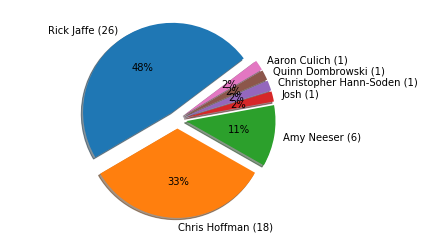

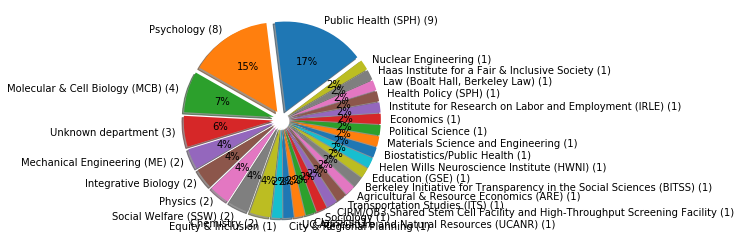

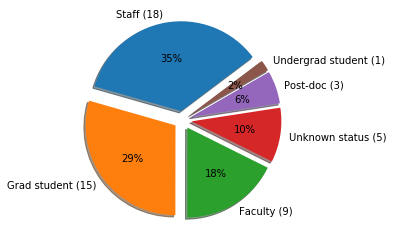

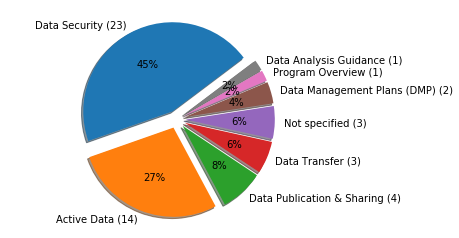

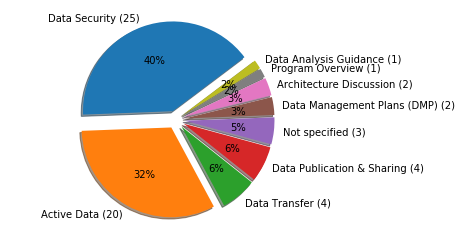

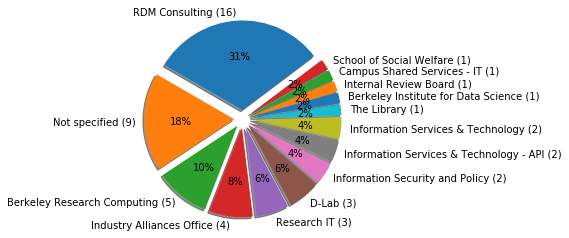

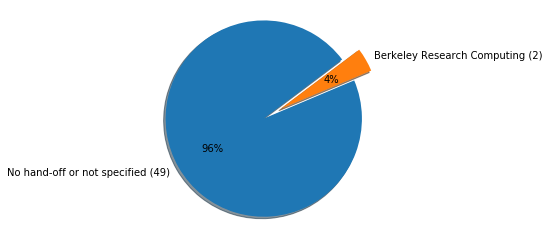

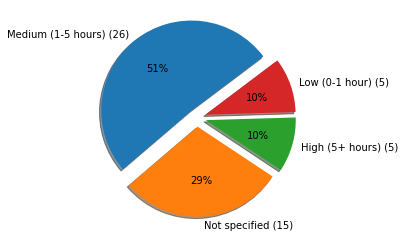

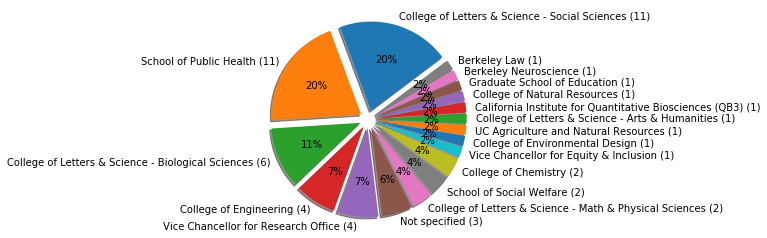

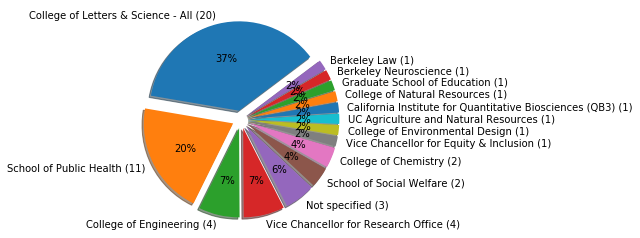

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

# Pie charts of each category, where the slices will be ordered and plotted counter-clockwise:
# Don't need pie charts of ssacount2 and ssacount3

for s in srtdlsts_wo_sa2_sa3:  # list of sorted lists without values for RIT service area 2 and 3
    
    labels = []
    sizes = []
    labelsplusn = []
    
    for pair in s:
        labels.append(pair[0])
        sizes.append(pair[1])

    #print(labels) #debug
    #print(sizes)  #debug
    
    for label, size in zip(labels, sizes):
        labelplusn = str(label) + ' (' + str(size) + ')'
        labelsplusn.append(labelplusn)
    
    #print(labelsplusn)  #debug
    
    explode = [.1 for _ in range(len(s))]  # one value for each element in len(sortedlist)
    
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=37)  # originally labels=labels
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()
    #print('\n\n')

The next set of cells generate each pie chart separately so we can customize them. 

NOTE: These need to be customized based on the date range: the number of arguments in the statement 'explode = ()'
must be equal to the number of items in the sorted list, and that will vary depending upon the range of time covered by the reporting period.

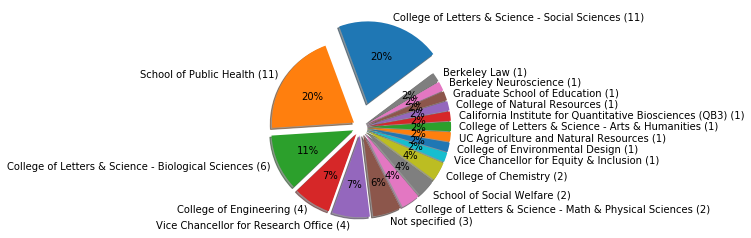

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt


# Pie chart of schools, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
labelsplusn = []

for pair in spacount:
    labels.append(pair[0])
    sizes.append(pair[1])
#print(labels) #debug
#print(sizes)  #debug
#print(len(labels))

for label, size in zip(labels, sizes):
    labelplusn = str(label) + ' (' + str(size) + ')'
    labelsplusn.append(labelplusn)

#print(labelsplusn)  #debug
    
explode = (.3, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=37)  # originally labels=labels
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
#plt.savefig('pie_spacount.png', bbox_inches='tight')

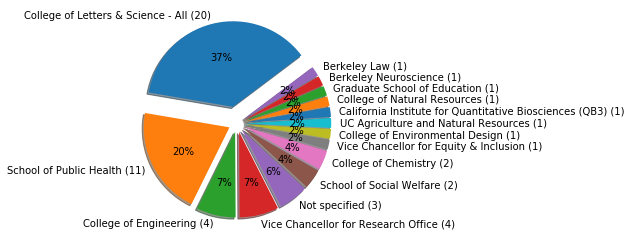

In [21]:
# Pie chart of schools with all L&S combined, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
labelsplusn = []

for pair in slscount:
    labels.append(pair[0])
    sizes.append(pair[1])
#print(labels) #debug
#print(sizes)  #debug
#print(len(labels))

for label, size in zip(labels, sizes):
    labelplusn = str(label) + ' (' + str(size) + ')'
    labelsplusn.append(labelplusn)

#print(labelsplusn)  #debug

explode = (.2, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1, .1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=37)  #originally labels=labels
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
#plt.savefig('pie_slscount.png', bbox_inches='tight')

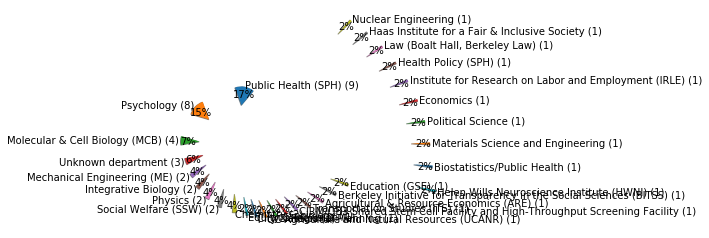

In [22]:
# Pie chart of original department/oru values, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
labelsplusn = []

for pair in sdcount:
    labels.append(pair[0])
    sizes.append(pair[1])
#print(labels) #debug
#print(sizes)  #debug

for label, size in zip(labels, sizes):
    labelplusn = str(label) + ' (' + str(size) + ')'
    labelsplusn.append(labelplusn)

#print(labelsplusn)  #debug

explode = (2.1, 1.9, 1.9, 1.8, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.3, 4.7, 5.1, 5.5, 10.1, 9.7, 9.5, 9.3, 9.1, 8.9, 8.7, 8.5, 8.3, 8.1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=50) # originally labels=labels
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
#plt.savefig('pie_sdcount.png', bbox_inches='tight')

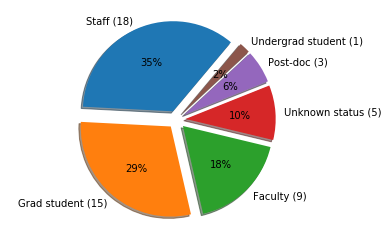

In [23]:
# Pie chart of position of client on campus, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
labelsplusn = []

for pair in spcount:
    labels.append(pair[0])
    sizes.append(pair[1])
#print(labels) #debug
#print(sizes)  #debug

for label, size in zip(labels, sizes):
    labelplusn = str(label) + ' (' + str(size) + ')'
    labelsplusn.append(labelplusn)

#print(labelsplusn)  #debug

explode = (.1, .1, .1, .1, .1, .1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=50) # originally labels=labels
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
#plt.savefig('pie_spcount.png', bbox_inches='tight')

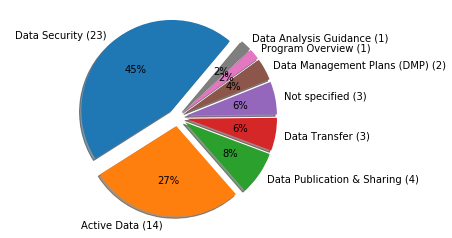

In [24]:
# Pie chart of RIT Service Area 1 values, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
labelsplusn = []

for pair in ssacount1:
    labels.append(pair[0])
    sizes.append(pair[1])
# print(labels) #debug
# print(sizes)  #debug

for label, size in zip(labels, sizes):
    labelplusn = str(label) + ' (' + str(size) + ')'
    labelsplusn.append(labelplusn)

#print(labelsplusn)  #debug

explode = (.1, .1, .1, .1, .1, .1, .1, .1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=50) # originally labels=labels
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
#plt.savefig('pie_ssacount.png', bbox_inches='tight')

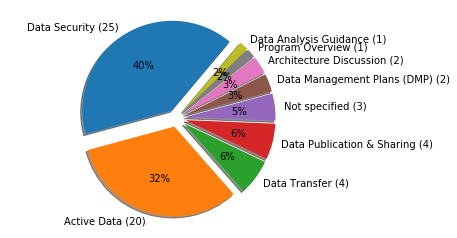

In [25]:
# Pie chart of RIT Service Area - All (merged) values, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
labelsplusn = []

for pair in ssacount_all:
    labels.append(pair[0])
    sizes.append(pair[1])
# print(labels) #debug
# print(sizes)  #debug

for label, size in zip(labels, sizes):
    labelplusn = str(label) + ' (' + str(size) + ')'
    labelsplusn.append(labelplusn)

#print(labelsplusn)  #debug

explode = (.1, .1, .1, .1, .1, .1, .1, .1, .1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=50) # originally labels=labels
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
#plt.savefig('pie_ssacount.png', bbox_inches='tight')

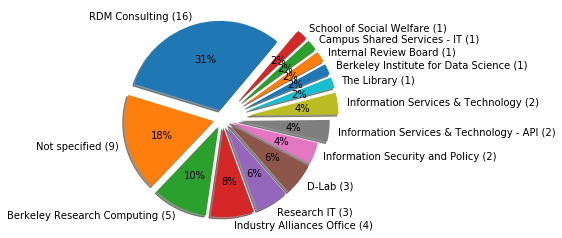

In [26]:
# Pie chart of sources (referrals in), where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
labelsplusn = []

for pair in sscount:
    labels.append(pair[0])
    sizes.append(pair[1])
# print(labels) #debug
# print(sizes)  #debug

for label, size in zip(labels, sizes):
    labelplusn = str(label) + ' (' + str(size) + ')'
    labelsplusn.append(labelplusn)

#print(labelsplusn)  #debug

explode = (.1, .1, .1, .1, .1, .1, .1, .2, .3, .3, .3, .3, .3, .3)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=50) # originally labels=labels
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
#plt.savefig('pie_sscount.png', bbox_inches='tight')

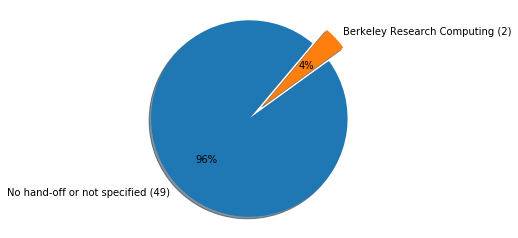

In [27]:
# Pie chart of referrals out, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
labelsplusn = []

for pair in srcount:
    labels.append(pair[0])
    sizes.append(pair[1])
# print(labels) #debug
# print(sizes)  #debug

for label, size in zip(labels, sizes):
    labelplusn = str(label) + ' (' + str(size) + ')'
    labelsplusn.append(labelplusn)

#print(labelsplusn)  #debug

explode = (.1, .1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=50) # originally labels=labels
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
#plt.savefig('pie_srcount.png', bbox_inches='tight')

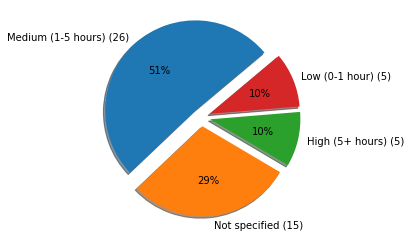

In [28]:
# Pie chart of complexity measures, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
labelsplusn = []

for pair in scocount:
    labels.append(pair[0])
    sizes.append(pair[1])
#print(labels) #debug
#print(sizes)  #debug

for label, size in zip(labels, sizes):
    labelplusn = str(label) + ' (' + str(size) + ')'
    labelsplusn.append(labelplusn)

#print(labelsplusn)  #debug

explode = (.1, .1, .1, .1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labelsplusn, autopct='%1.f%%',
        shadow=True, startangle=40) # originally labels=labels
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
#plt.savefig('pie_scocount.png', bbox_inches='tight')

Print the top five values in each category (or all values, if less than five)

In [29]:
for lst, hdr in zip(srtdlsts, all_headings):
    print('\n' + 'Top Five: ' + hdr)
    for i in range(5):
        if i >= len(lst): continue
        (k,v) = lst[i]
        print(str(i+1) + '. ' + k + ': ' + str(v))
            
    


Top Five: Consultants, number of consultations
1. Rick Jaffe: 26
2. Chris Hoffman: 18
3. Amy Neeser: 6
4. Josh: 1
5. Christopher Hann-Soden: 1

Top Five: Departments Served, number of engagements
1. Public Health (SPH): 9
2. Psychology: 8
3. Molecular & Cell Biology (MCB): 4
4. Unknown department: 3
5. Mechanical Engineering (ME): 2

Top Five: Researcher Status, number of researchers
1. Staff: 18
2. Grad student: 15
3. Faculty: 9
4. Unknown status: 5
5. Post-doc: 3

Top Five: RIT Service Area 1: service area, number of cases
1. Data Security: 23
2. Active Data: 14
3. Data Publication & Sharing: 4
4. Data Transfer: 3
5. Not specified: 3

Top Five: RIT Service Area 2: service area, number of cases
1. None or Not specified: 41
2. Active Data: 6
3. Data Security: 2
4. Architecture Discussion: 1
5. Data Transfer: 1

Top Five: RIT Service Area 3: service area, number of cases
1. None or Not specified: 50
2. Architecture Discussion: 1

Top Five: Referrals In: from group or unit, number of ca